In [1]:
import tensorflow as tf
import sonnet as snt
import numpy as np
import matplotlib.pyplot as plt

% matplotlib inline

In [2]:
img_size = 10, 10
glimpse_size = 5, 5

x = abs(np.random.randn(1, *img_size)) * .3
x[0, 3:6, 3:6] = 1

# Make a crop
crop = x[0, 2:7, 2:7]

In [3]:
def gaussian_mask(u, s, d, R, C):
    """
    :param u: tf.Tensor, centre of the first Gaussian.
    :param s: tf.Tensor, standard deviation of Gaussians.
    :param d: tf.Tensor, shift between Gaussian centres.
    :param R: int, number of rows in the mask, there is one Gaussian per row.
    :param C: int, number of columns in the mask.
    """
    # indices to create centres
    R = tf.to_float(tf.reshape(tf.range(R), (1, 1, R)))
    C = tf.to_float(tf.reshape(tf.range(C), (1, C, 1)))
    centres = u[np.newaxis, :, np.newaxis] + R * d
    column_centres = C - centres
    mask = tf.exp(-.5 * tf.square(column_centres / s))
    # we add eps for numerical stability
    normalised_mask = mask / (tf.reduce_sum(mask, 1, keep_dims=True) + 1e-8)
    return normalised_mask

def gaussian_glimpse(img_tensor, transform_params, crop_size):
    """
    :param img_tensor: tf.Tensor of size (batch_size, Height, Width, channels)
    :param transform_params: tf.Tensor of size (batch_size, 6), where params are  (mean_y, std_y, d_y, mean_x, std_x, d_x) specified in pixels.
    :param crop_size): tuple of 2 ints, size of the resulting crop
    """
    # parse arguments
    h, w = crop_size
    H, W = img_tensor.shape.as_list()[1:3]
    split_ax = transform_params.shape.ndims -1
    uy, sy, dy, ux, sx, dx = tf.split(transform_params, 6, split_ax)
    # create Gaussian masks, one for each axis
    Ay = gaussian_mask(uy, sy, dy, h, H)
    Ax = gaussian_mask(ux, sx, dx, w, W)
    # extract glimpse
    glimpse = tf.matmul(tf.matmul(Ay, img_tensor, adjoint_a=True), Ax)
    return glimpse

def spatial_transformer(img_tensor, transform_params, crop_size):
    """
    :param img_tensor: tf.Tensor of size (batch_size, Height, Width, channels)
    :param transform_params: tf.Tensor of size (batch_size, 4), where params are  (scale_y, shift_y, scale_x, shift_x)
    :param crop_size): tuple of 2 ints, size of the resulting crop
    """
    constraints = snt.AffineWarpConstraints.no_shear_2d()
    img_size = img_tensor.shape.as_list()[1:]
    warper = snt.AffineGridWarper(img_size, crop_size, constraints)
    grid_coords = warper(transform_params)
    glimpse = snt.resampler(img_tensor[..., tf.newaxis], grid_coords)
    return glimpse

In [4]:
tf.reset_default_graph()

# placeholders
tx = tf.placeholder(tf.float32, x.shape)
tu = tf.placeholder(tf.float32, [1])
ts = tf.placeholder(tf.float32, [1])
td = tf.placeholder(tf.float32, [1])
stn_params = tf.placeholder(tf.float32, [1, 4], 'stn_params')

In [5]:
# Gaussian Attention
gaussian_att_params = tf.concat([tu, ts, td, tu, ts, td], -1)
gaussian_glimpse_expr = gaussian_glimpse(tx, gaussian_att_params, glimpse_size)

In [6]:
# Spatial Transformer
stn_glimpse_expr = spatial_transformer(tx, stn_params, glimpse_size)

In [7]:
sess = tf.Session()

# extract a Gaussian glimpse
u = 2
s = .5
d = 1
u, s, d = (np.asarray([i]) for i in (u, s, d))
gaussian_crop = sess.run(gaussian_glimpse_expr, feed_dict={tx: x, tu: u, ts: s, td: d})

# extract STN glimpse
transform = [.4, -.1, .4, -.1]
transform = np.asarray(transform).reshape((1, 4))
stn_crop = sess.run(stn_glimpse_expr, {tx: x, stn_params: transform})

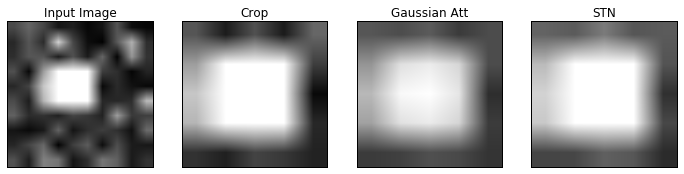

In [8]:
# plots
fig, axes = plt.subplots(1, 4, figsize=(12, 3))

titles = ['Input Image', 'Crop', 'Gaussian Att', 'STN']
imgs = [x, crop, gaussian_crop, stn_crop]
for ax, title, img in zip(axes, titles, imgs):
    ax.imshow(img.squeeze(), cmap='gray', vmin=0., vmax=1.)
    ax.set_title(title)
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)

In [9]:
fig.savefig('attention_example.png', dpi=300, bbox_inches='tight')